# I’m Something of a Painter Myself

Use GANs to create art with [data from Kaggle](https://www.kaggle.com/competitions/gan-getting-started).

The task is to create a generative adversarial network that can generate images Monet-style images from real photos.

The data consist of 300 Monet images and 7038 photos images. 

The data contains [`tfrec` files](https://www.tensorflow.org/tutorials/load_data/tfrecord ) already. Which lead me to use TensorFlow instead of Torch and Torchvision for my pipeline. 

In [3]:
# !pip install pillow matplotlib numpy tensorflow tensorflow[and-cuda]

In [22]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# !kaggle competitions download -c gan-getting-started
# !unzip gan-getting-started.zip -d data

## Exploratory Data Analysis

Number of Monet images: 300


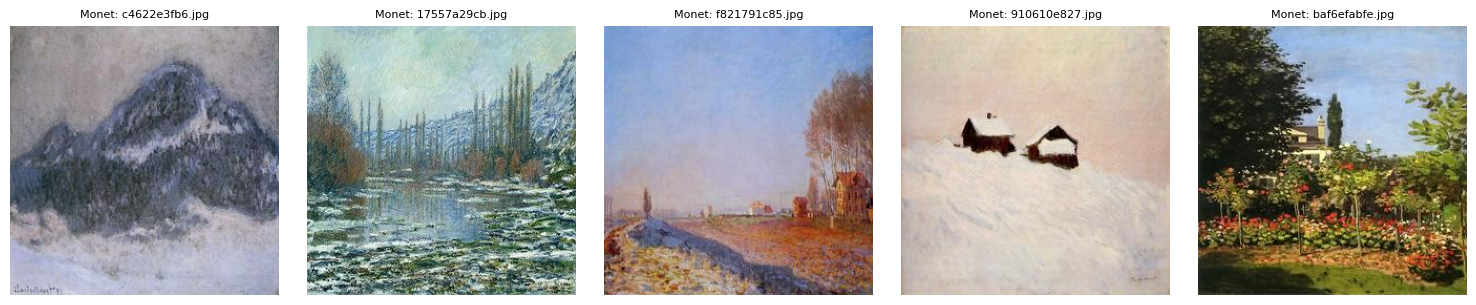

Number of Photo images: 7038


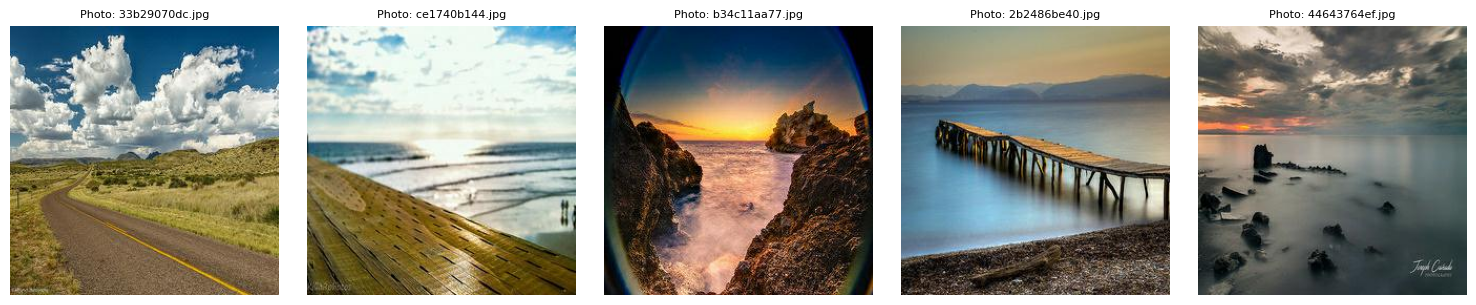

In [18]:
monet_jpg_dir = "data/monet_jpg"
photo_jpg_dir = "data/photo_jpg"

def load_random_images(directory, n=5):
    files = [f for f in os.listdir(directory) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    selected = random.sample(files, n)
    images = [Image.open(os.path.join(directory, f)).convert("RGB") for f in selected]
    return images, selected

def show_images(images, titles=None, title_prefix=""):
    n = len(images)
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        if titles:
            plt.title(f"{title_prefix}{titles[i]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

monet_images, monet_titles = load_random_images(monet_jpg_dir, n=5)
print(f"Number of Monet images: {len(os.listdir(monet_jpg_dir))}")
show_images(monet_images, monet_titles, title_prefix="Monet: ")

photo_images, photo_titles = load_random_images(photo_jpg_dir, n=5)
print(f"Number of Photo images: {len(os.listdir(photo_jpg_dir))}")
show_images(photo_images, photo_titles, title_prefix="Photo: ")

# Model Building

In [7]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        normalized = (x - mean) / tf.sqrt(var + self.epsilon)
        return self.gamma * normalized + self.beta

def resnet_block(x, filters):
    init = x
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.Add()([x, init])
    return x

def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))

    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(9):
        x = resnet_block(x, 256)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return keras.Model(inputs, x, name="generator")

def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)
    return keras.Model(inputs, x, name="discriminator")

In [8]:
G_photo2monet = build_generator()
G_monet2photo = build_generator()
D_photo = build_discriminator()
D_monet = build_discriminator()

I0000 00:00:1744994149.590720   22121 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7795 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


## Training

In [9]:
monet_tfrecords = sorted(glob("data/monet_tfrec/*.tfrec"))
photo_tfrecords = sorted(glob("data/photo_tfrec/*.tfrec"))

def decode_image(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0
    return image

def get_dataset(tfrecord_files, batch_size=1, shuffle=True):
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

photo_ds = get_dataset(photo_tfrecords)
monet_ds = get_dataset(monet_tfrecords)

In [ ]:
loss_fn = keras.losses.MeanSquaredError()

def discriminator_loss(real, fake):
    real_loss = loss_fn(tf.ones_like(real), real)
    fake_loss = loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake):
    return loss_fn(tf.ones_like(fake), fake)

def cycle_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled)) * 10.0

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same)) * 5.0

lr = 2e-4
G_photo2monet_opt = keras.optimizers.Adam(lr, beta_1=0.5)
G_monet2photo_opt = keras.optimizers.Adam(lr, beta_1=0.5)
D_photo_opt = keras.optimizers.Adam(lr, beta_1=0.5)
D_monet_opt = keras.optimizers.Adam(lr, beta_1=0.5)


@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = G_photo2monet(real_photo, training=True)
        fake_photo = G_monet2photo(real_monet, training=True)

        cycled_photo = G_monet2photo(fake_monet, training=True)
        cycled_monet = G_photo2monet(fake_photo, training=True)

        same_photo = G_monet2photo(real_photo, training=True)
        same_monet = G_photo2monet(real_monet, training=True)

        disc_real_photo = D_photo(real_photo, training=True)
        disc_real_monet = D_monet(real_monet, training=True)
        disc_fake_photo = D_photo(fake_photo, training=True)
        disc_fake_monet = D_monet(fake_monet, training=True)

        gen_g_loss = generator_loss(disc_fake_monet)
        gen_f_loss = generator_loss(disc_fake_photo)

        cyc_loss = cycle_loss(real_photo, cycled_photo) + cycle_loss(real_monet, cycled_monet)
        id_loss = identity_loss(real_photo, same_photo) + identity_loss(real_monet, same_monet)

        total_g_loss = gen_g_loss + gen_f_loss + cyc_loss + id_loss

        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)

    G_photo2monet_opt.apply_gradients(zip(tape.gradient(total_g_loss, G_photo2monet.trainable_variables), G_photo2monet.trainable_variables))
    G_monet2photo_opt.apply_gradients(zip(tape.gradient(total_g_loss, G_monet2photo.trainable_variables), G_monet2photo.trainable_variables))

    D_photo_opt.apply_gradients(zip(tape.gradient(disc_photo_loss, D_photo.trainable_variables), D_photo.trainable_variables))
    D_monet_opt.apply_gradients(zip(tape.gradient(disc_monet_loss, D_monet.trainable_variables), D_monet.trainable_variables))

    return {
        "G_loss": total_g_loss,
        "D_photo_loss": disc_photo_loss,
        "D_monet_loss": disc_monet_loss
    }

In [17]:
# Debugging an issue with TensorFlow and cuDNN with ym GPU
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
!cat /usr/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
#define CUDNN_MAJOR 9
#define CUDNN_MINOR 8
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 10000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

/* cannot use constexpr here since this is a C-only file */


In [16]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for i, (real_photo, real_monet) in enumerate(tf.data.Dataset.zip((photo_ds, monet_ds))):
        logs = train_step(real_photo, real_monet)

        if i % 100 == 0:
            print(f"[{i}] G_loss: {logs['G_loss']:.2f}, "
                  f"D_photo: {logs['D_photo_loss']:.2f}, "
                  f"D_monet: {logs['D_monet_loss']:.2f}")


Epoch 1/10
[0] G_loss: 7.41, D_photo: 0.22, D_monet: 0.23
[100] G_loss: 11.44, D_photo: 0.20, D_monet: 0.25
[200] G_loss: 10.59, D_photo: 0.26, D_monet: 0.12

Epoch 2/10
[0] G_loss: 9.14, D_photo: 0.21, D_monet: 0.32
[100] G_loss: 13.27, D_photo: 0.27, D_monet: 0.19
[200] G_loss: 8.09, D_photo: 0.28, D_monet: 0.13


2025-04-18 16:44:24.890522: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 3/10
[0] G_loss: 7.01, D_photo: 0.16, D_monet: 0.19
[100] G_loss: 9.56, D_photo: 0.26, D_monet: 0.22
[200] G_loss: 8.01, D_photo: 0.38, D_monet: 0.20

Epoch 4/10
[0] G_loss: 7.30, D_photo: 0.23, D_monet: 0.12
[100] G_loss: 9.39, D_photo: 0.19, D_monet: 0.10
[200] G_loss: 9.23, D_photo: 0.15, D_monet: 0.27

Epoch 5/10
[0] G_loss: 9.52, D_photo: 0.06, D_monet: 0.32
[100] G_loss: 10.09, D_photo: 0.34, D_monet: 0.17
[200] G_loss: 8.57, D_photo: 0.12, D_monet: 0.16

Epoch 6/10
[0] G_loss: 6.00, D_photo: 0.28, D_monet: 0.17
[100] G_loss: 6.15, D_photo: 0.14, D_monet: 0.13
[200] G_loss: 8.36, D_photo: 0.46, D_monet: 0.24


2025-04-18 16:48:47.448663: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 7/10
[0] G_loss: 7.80, D_photo: 0.28, D_monet: 0.30
[100] G_loss: 6.12, D_photo: 0.20, D_monet: 0.23
[200] G_loss: 6.89, D_photo: 0.09, D_monet: 0.31

Epoch 8/10
[0] G_loss: 5.82, D_photo: 0.18, D_monet: 0.20
[100] G_loss: 6.24, D_photo: 0.05, D_monet: 0.13
[200] G_loss: 8.00, D_photo: 0.39, D_monet: 0.23

Epoch 9/10
[0] G_loss: 6.65, D_photo: 0.16, D_monet: 0.11
[100] G_loss: 5.49, D_photo: 0.21, D_monet: 0.12
[200] G_loss: 5.38, D_photo: 0.13, D_monet: 0.36

Epoch 10/10
[0] G_loss: 6.96, D_photo: 0.10, D_monet: 0.13
[100] G_loss: 6.17, D_photo: 0.21, D_monet: 0.17
[200] G_loss: 6.88, D_photo: 0.20, D_monet: 0.20


# Results

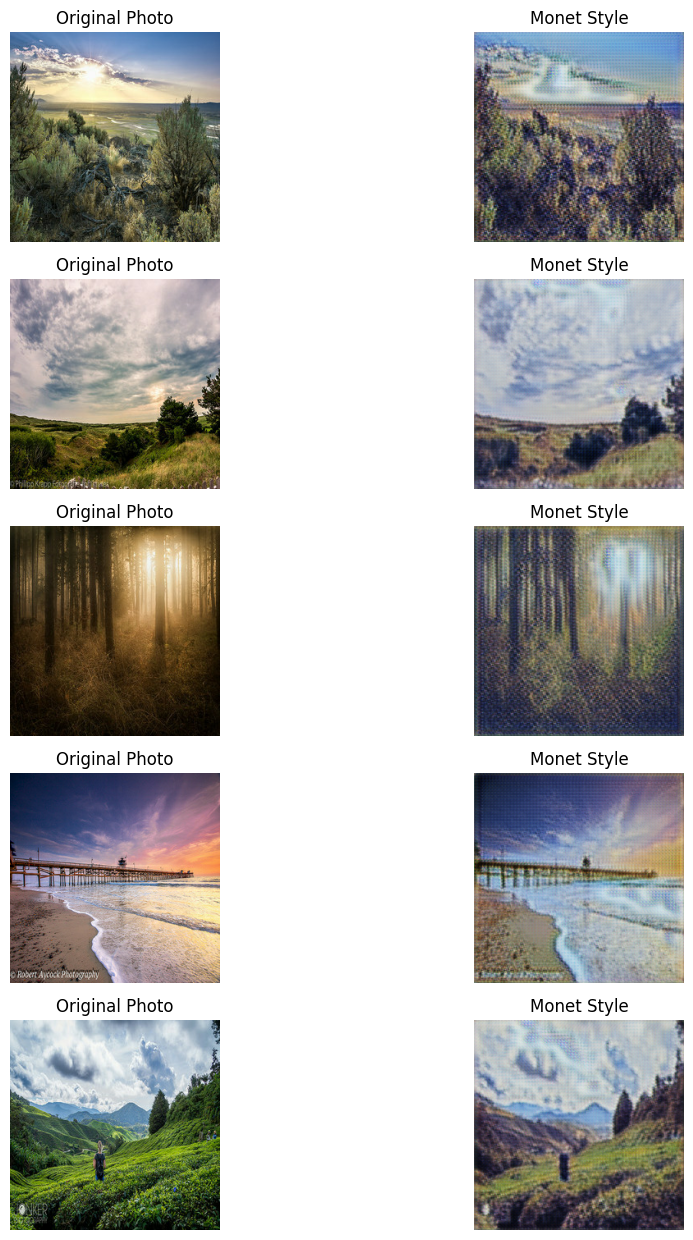

In [ ]:
def show_photo_to_monet(generator, dataset, num_images=5):
    plt.figure(figsize=(12, num_images * 2.5))
    for i, photo in enumerate(dataset.take(num_images)):
        generated = generator(photo, training=False)

        real_img = (photo[0] + 1.0) / 2.0
        fake_img = (generated[0] + 1.0) / 2.0

        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(real_img)
        plt.title("Original Photo")
        plt.axis("off")

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(fake_img)
        plt.title("Monet Style")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_photo_to_monet(G_photo2monet, photo_ds, num_images=5)

# Conclusion

This was the most challenging so far. I went with Tensorflow over Torch for this project because data already included tfrec encoded images. I reviewed the cycleGAN, pix2pix, and neural style transfer tutorials on tensorflow.org to get an understanding of implementing a GAN with Tensorflow.

I also had to look into getting cuDNN because by default tensorflow wanted to use my GPU even though it originally wasn't setup proper. With Torch, I can set a device like cpu, gpu or mps in the notebook. Later when I went to submit to kaggle, I found out that you can disable the GPU with `os.environ["CUDA_VISIBLE_DEVICES"] = "-1"` because I didn't have access to the GPU accelerator in kaggle.

I tried this first down-sampling the images to 128x128 and just 1 epoch to make sure everything functioned. Afterwards I went to 256x256 and looped over it 10 times. I'm not impressed with my results. The results look like noisy, blurry version of the originals, but I can see the direction of the process. Brush strokes do look like noise and the features in Monet paintings are "soft."

- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://www.tensorflow.org/tutorials/generative/pix2pix
- https://www.tensorflow.org/tutorials/generative/style_transfer
- https://www.digitalocean.com/community/tutorials/install-cuda-cudnn-for-gpu